In [4]:
from darts.models import NHiTSModel, RNNModel, TiDEModel, TCNModel
from darts import metrics
from darts import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

In [2]:
wiki_traffic = pd.read_csv('../web_traffic/web_traffic.csv')

In [3]:
wiki_traffic.shape

(145063, 551)

In [93]:
def get_random_page():
    while True:
        random_number = random.randint(0, wiki_traffic.shape[0] - 1)
        page = wiki_traffic.iloc[random_number].fillna(0).iloc[1:]
        if max(page) <= 200 and np.average(page) >= 10:
            break
    
    print(f'{random_number} selected')
    page.index = pd.to_datetime(page.index)
    page_series = TimeSeries.from_series(page)
    page_series.plot()
    return page_series

In [69]:
def split_data(darts_series):
    train, validation = darts_series[ : int(len(darts_series) * 0.7)] , darts_series[int(len(darts_series) * 0.7) : ]
    return train, validation

In [73]:
class Training:
    def __init__(self, data):
        self.data = data

    def train_NHits(self):
        model = NHiTSModel(
                input_chunk_length=8,
                output_chunk_length=8,
                num_stacks = 6 ,
                num_blocks = 2 ,
                num_layers = 4 ,
                n_epochs=300,
                pl_trainer_kwargs={
                "accelerator": "gpu",
                "devices": [0]
                },
            )
        model.fit(self.data, verbose=True)
        return model

    def train_rnn(self):
        model = RNNModel(
                model="LSTM",
                input_chunk_length=7,
                hidden_dim=32,
                n_rnn_layers=2,
                training_length=32,
                n_epochs=1300,
                pl_trainer_kwargs={
                "accelerator": "gpu",
                "devices": [0]
                },
            )
        model.fit(self.data, verbose=True)
        return model
    
    def train_tcn(self):
        model = TCNModel(
            input_chunk_length=8,
            output_chunk_length=7,
            kernel_size = 3,
            num_filters =  4,
            num_layers = 4,
            dilation_base = 4,
            weight_norm = True,
            dropout =  0.1,
            n_epochs= 1300,
               pl_trainer_kwargs={
                "accelerator": "gpu",
                "devices": [0]
                }, 
        )

        model.fit(self.data, verbose=True)
        return model
    
    def train_tide(self):
        model = TiDEModel(
            input_chunk_length=8,
            output_chunk_length=8,
            num_encoder_layers = 2, 
            num_decoder_layers = 2,
            decoder_output_dim = 16,
            hidden_size = 256,
            temporal_width_past = 7, 
            temporal_width_future = 7,
            temporal_decoder_hidden = 64,
            dropout = 0.1,
            n_epochs= 300,
               pl_trainer_kwargs={
                "accelerator": "gpu",
                "devices": [0]
                },
        )
        model.fit(self.data, verbose=True)
        return model

    

In [74]:
def save_csvs(val, pred):
    np.savetxt(f"../testing_traffic/{val.columns[0]}_actual_traffic.csv", val.values(), delimiter=',', fmt='%d')
    np.savetxt(f"../testing_traffic/{pred.columns[0]}_predicted_traffic.csv", pred.values(), delimiter=',', fmt='%d')

82250 selected


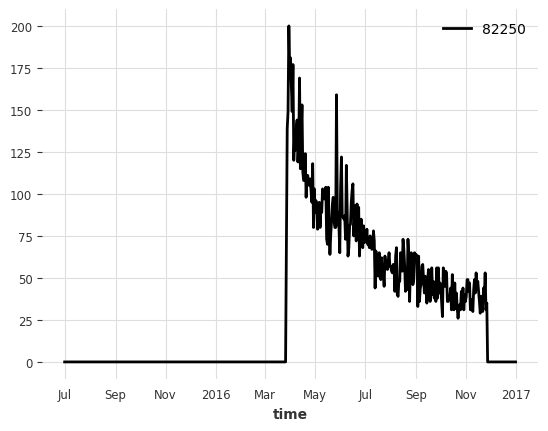

In [286]:
page_traffic = get_random_page()
train, val = split_data(page_traffic)

In [287]:
t = Training(train)
nhits = t.train_NHits()
rnn = t.train_rnn()
tcn = t.train_tcn()
tide = t.train_tide()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.6 M 
---------------------------------------------------
9.6 M     Trainable params
4.1 K     Non-trainable params
9.6 M     Total params
38.245    Total estimated model params size (MB)


Epoch 299: 100%|██████████| 12/12 [00:00<00:00, 25.16it/s, train_loss=1.43e+3]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 12/12 [00:00<00:00, 25.06it/s, train_loss=1.43e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 12.9 K
4 | V             | Linear           | 33    
---------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Epoch 1299: 100%|██████████| 12/12 [00:00<00:00, 67.70it/s, train_loss=215.0]  

`Trainer.fit` stopped: `max_epochs=1300` reached.


Epoch 1299: 100%|██████████| 12/12 [00:00<00:00, 66.94it/s, train_loss=215.0]


c:\Users\wangh\OneDrive\Desktop\repo\6446\myenv\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 383   
----------------------------------------------------
383       Trainable params
0         Non-trainable params
383       Total params
0.002   

Epoch 1299: 100%|██████████| 12/12 [00:00<00:00, 84.87it/s, train_loss=1.71e+3]

`Trainer.fit` stopped: `max_epochs=1300` reached.


Epoch 1299: 100%|██████████| 12/12 [00:00<00:00, 83.69it/s, train_loss=1.71e+3]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 267 K 
4 | decoders         | Sequential       | 328 K 
5 | temporal_decoder | _ResidualBlock   | 1.2 K 
6 | lookback_skip    | Linear           | 72    
------------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.392     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 12/12 [00:00<00:00, 91.94it/s, train_loss=20.30]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 12/12 [00:00<00:00, 90.55it/s, train_loss=20.30]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


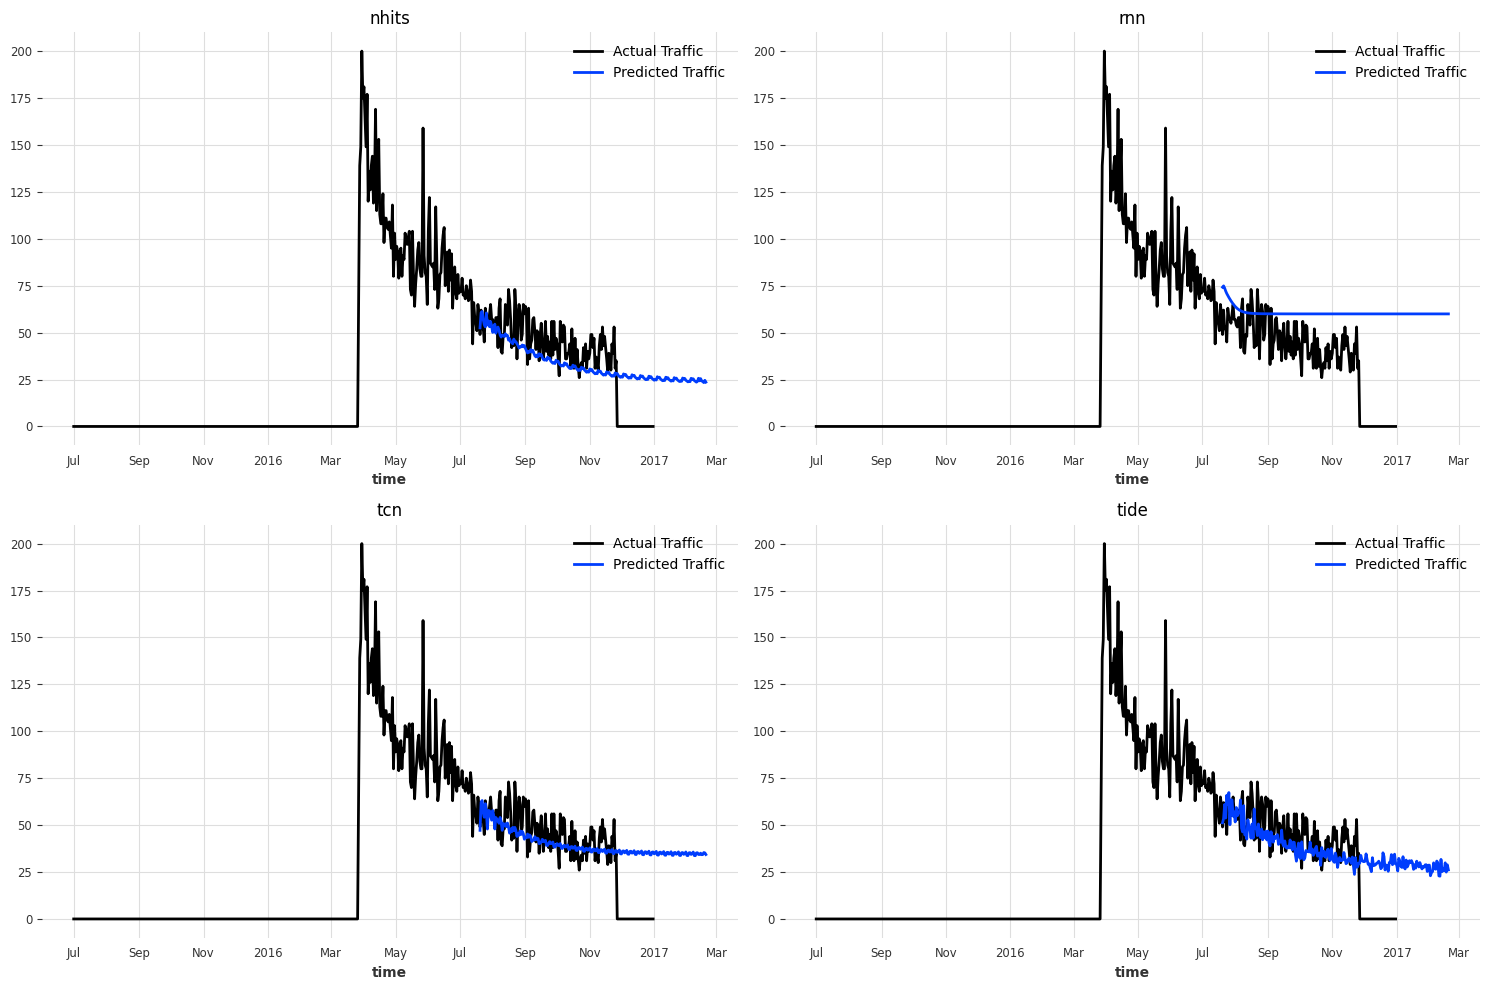

In [288]:
models = {
    "nhits": nhits,
    "rnn": rnn,
    "tcn": tcn,
    "tide": tide
}

corner_mapping = {
    0:[0, 0] , 
    1:[0, 1] ,
    2:[1, 0] ,
    3:[1, 1] ,
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (model_name, model) in enumerate(models.items()):
    forecast = model.predict(len(val) + 50)

    page_traffic.plot(label='Actual Traffic', ax= axes[corner_mapping[i][0], corner_mapping[i][1]] )
    forecast.plot(label='Predicted Traffic',  ax= axes[corner_mapping[i][0], corner_mapping[i][1]] )

    axes[corner_mapping[i][0], corner_mapping[i][1]].set_title(model_name)


plt.tight_layout()
plt.savefig(f"../plots/{page_traffic.columns[0]}_models_outputs.png")
plt.show()

In [289]:
with open(f'../metrics/{page_traffic.columns[0]}_models_metrics.txt', 'w') as file:

    original_values = val.values()
    original_time_index = val.time_index
    original_values[original_values == 0] = 0.0001

    adjusted_val = TimeSeries.from_times_and_values(original_time_index, original_values)

    
    file.write(f"{'Model':<10} {'MAPE':<10} {'MAE':<10} {'MARRE':<10} {'MSE':<10} {'OPE':<10} {'RMSE':<10}\n")
    
    models = ["nhits", "rnn", "tcn", "tide"]
    pred_nhits = nhits.predict(len(val))
    pred_rnn = rnn.predict(len(val))
    pred_tcn = tcn.predict(len(val))
    pred_tide = tide.predict(len(val))

    mapes = [  
      metrics.metrics.mape(adjusted_val, pred_nhits),
      metrics.metrics.mape(adjusted_val, pred_rnn),
      metrics.metrics.mape(adjusted_val, pred_tcn),
      metrics.metrics.mape(adjusted_val, pred_tide),  
     ]
    
    maes = [
      metrics.metrics.mae(adjusted_val, pred_nhits),
      metrics.metrics.mae(adjusted_val, pred_rnn),
      metrics.metrics.mae(adjusted_val, pred_tcn),
      metrics.metrics.mae(adjusted_val, pred_tide),  
    ]

    marres = [
      metrics.metrics.marre(adjusted_val, pred_nhits),
      metrics.metrics.marre(adjusted_val, pred_rnn),
      metrics.metrics.marre(adjusted_val, pred_tcn),
      metrics.metrics.marre(adjusted_val, pred_tide),  
    ]

    mses = [
      metrics.metrics.mse(adjusted_val, pred_nhits),
      metrics.metrics.mse(adjusted_val, pred_rnn),
      metrics.metrics.mse(adjusted_val, pred_tcn),
      metrics.metrics.mse(adjusted_val, pred_tide),  
    ]

    opes = [
      metrics.metrics.ope(adjusted_val, pred_nhits),
      metrics.metrics.ope(adjusted_val, pred_rnn),
      metrics.metrics.ope(adjusted_val, pred_tcn),
      metrics.metrics.ope(adjusted_val, pred_tide),  
    ]

    rmses = [
      metrics.metrics.rmse(adjusted_val, pred_nhits),
      metrics.metrics.rmse(adjusted_val, pred_rnn),
      metrics.metrics.rmse(adjusted_val, pred_tcn),
      metrics.metrics.rmse(adjusted_val, pred_tide),  
    ]


    for model, mape, mae, marre, mse, ope, rmse in zip(models, mapes, maes, marres, mses, opes, rmses):
        file.write(f'''{model:<10} {round(mape, 2):<10} {round(mae, 2):<10} {round(marre, 2):<10} {round(mse, 2):<10} {round(ope, 2):<10} {round(rmse, 2):<10} \n''')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


In [180]:
save_csvs(val, pred_tide)